In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tsa.api import VAR
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf


### Analisi Esplorativa dei dati

In [2]:
df = pandas.read_csv('data/theft_df.csv')

display(df)

,geo,year,theft,poverty,neet,education,income,inequity
0,Austria,2016,1651.67,17.835966,8.091438,34.540870,24400,4.09
1,Belgium,2016,2055.54,26.581125,13.799563,50.108248,22267,3.85
2,Bulgaria,2016,457.48,33.837398,16.024476,23.464412,3212,7.69
3,Cyprus,2016,86.17,1.968100,1.526974,4.767553,14132,4.88
4,Czechia,2016,674.86,17.308303,11.714766,34.405528,7905,3.50
...,...,...,...,...,...,...,...,...
157,Portugal,2021,621.02,23.582997,9.783339,48.916697,11115,5.66
158,Romania,2021,471.44,80.070931,38.979374,44.739872,4914,7.14
159,Sweden,2021,2784.26,20.447211,6.227577,51.169924,25925,4.04
160,Slovenia,2021,634.76,2.319875,1.539553,10.102000,15415,3.24


<Axes: >

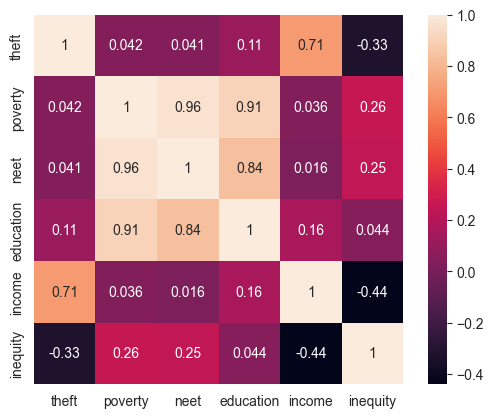

In [3]:
# Correlation Matrix

corrmat = df.drop(columns=["geo", "year"]).corr()

sns.heatmap(corrmat, square=True, annot=True)

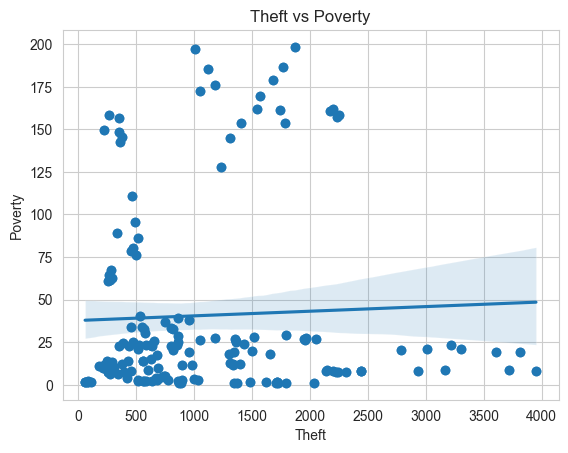

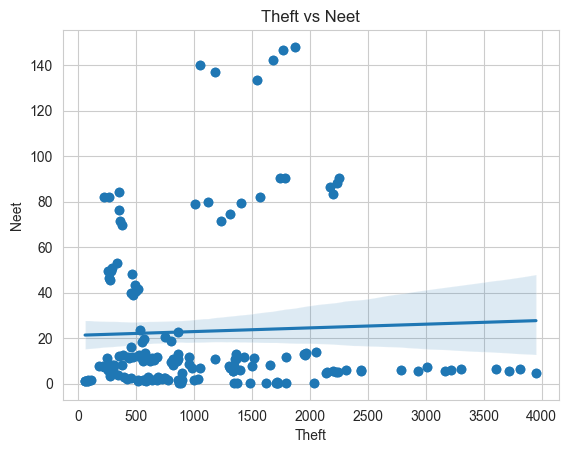

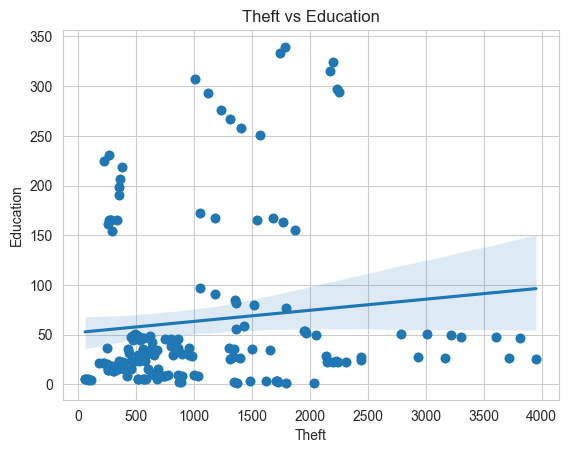

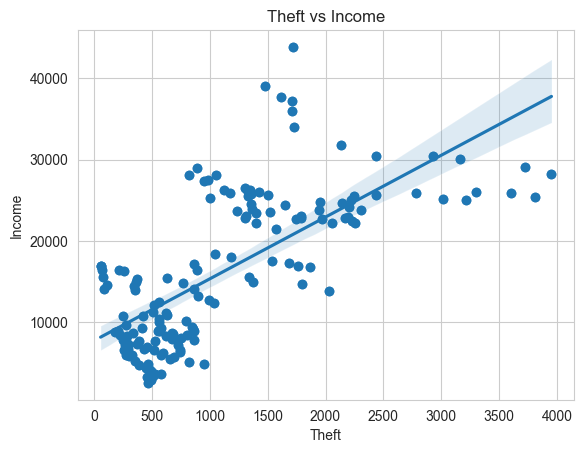

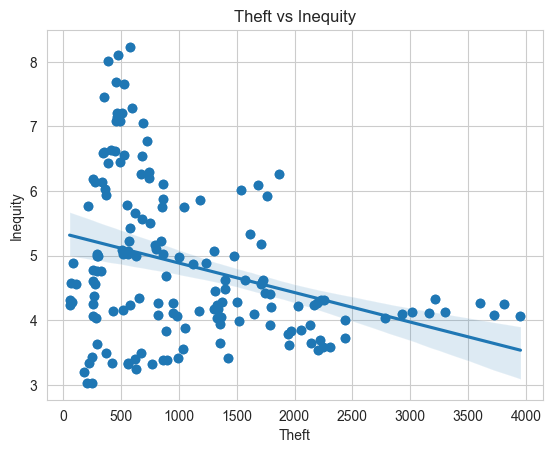

In [4]:
# Scatter Plot
sns.regplot(x="theft", y="poverty", data=df)
plt.scatter(df["theft"], df["poverty"])
plt.xlabel("Theft")
plt.ylabel("Poverty")
plt.title("Theft vs Poverty")
plt.show()

######

sns.regplot(x="theft", y="neet", data=df)
plt.scatter(df["theft"], df["neet"])
plt.xlabel("Theft")
plt.ylabel("Neet")
plt.title("Theft vs Neet")
plt.show()

######

sns.regplot(x="theft", y="education", data=df)
plt.scatter(df["theft"], df["education"])
plt.xlabel("Theft")
plt.ylabel("Education")
plt.title("Theft vs Education")
plt.show()

######

sns.regplot(x="theft", y="income", data=df)
plt.scatter(df["theft"], df["income"])
plt.xlabel("Theft")
plt.ylabel("Income")
plt.title("Theft vs Income")
plt.show()

######

sns.regplot(x="theft", y="inequity", data=df)
plt.scatter(df["theft"], df["inequity"])
plt.xlabel("Theft")
plt.ylabel("Inequity")
plt.title("Theft vs Inequity")
plt.show()

# Modeling

In [5]:
X = df.drop(columns=["geo", "year", "theft"])
y = df["theft"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.42651204673959975

In [6]:
# ANOVA MODEL 

model = ols("theft ~ poverty + neet + education + income + inequity", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                 sum_sq     df           F        PR(>F)
poverty    5.098444e+03    1.0    0.013560  9.074462e-01
neet       1.484341e+05    1.0    0.394794  5.307092e-01
education  9.079078e+04    1.0    0.241478  6.238311e-01
income     4.459626e+07    1.0  118.613699  6.711488e-21
inequity   1.079801e+05    1.0    0.287197  5.927855e-01
Residual   5.865272e+07  156.0         NaN           NaN


In [7]:
# OSL 
X = df.drop(columns=["geo", "year", "theft"])
y = df["theft"]

X2 = sm.add_constant(X)
model = sm.OLS(y, X2)
est2 = model.fit()

result_fr = model.fit_regularized(method="elastic_net", alpha=0.02, L1_wt=0, start_params=est2.params)

final = sm.regression.linear_model.OLSResults(model, result_fr.params, model.normalized_cov_params)

print(final.summary())

                            OLS Regression Results                            
Dep. Variable:                  theft   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     31.42
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           4.82e-22
Time:                        12:05:48   Log-Likelihood:                -1266.7
No. Observations:                 162   AIC:                             2545.
Df Residuals:                     156   BIC:                             2564.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.3575    300.394      0.334      0.7

ValueError: x and y must have same first dimension, but have shapes (162, 6) and (33,)

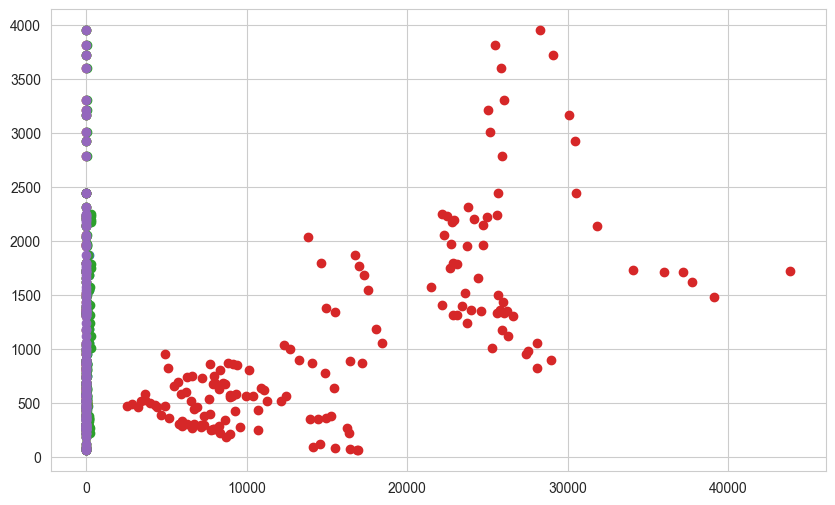

In [9]:
pred_ols = final.get_prediction()

iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X, y, "o", label="data")
ax.plot(X2, y_test, "b-", label="True") 
ax.plot(X2, final.fittedvalues, "r--.", label="OLS")
ax.plot(X2, iv_u, "r--")
ax.plot(X2, iv_l, "r--")
ax.legend(loc="best")
plt.show()